In [2]:
import torch, torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode

# Text related imports
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd gdrive/My Drive/

In [3]:
!pip install easy-vqa

     |████████████████████████████████| 3.2MB 8.8MB/s 


**Torch library version**

In [4]:
print("torch version: ", torch.__version__)
print("is cuda available: ", torch.cuda.is_available())

torch version:  1.8.1+cu101
is cuda available:  True


**Load VQA Data**

In [5]:
from easy_vqa import get_train_questions, get_test_questions
from easy_vqa import get_train_image_paths, get_test_image_paths

In [6]:
train_questions, train_answers, train_image_ids = get_train_questions()
test_questions, test_answers, test_image_ids = get_test_questions()

train_image_paths = get_train_image_paths()
test_image_paths = get_test_image_paths()

print("len of train examples: ", len(train_image_paths))
print("len of test examples: ", len(test_image_paths))

len of train examples:  4000
len of test examples:  1000


**Create vocab and set minimum frequency for vacab**

In [7]:
counter = Counter()
tokenizer = get_tokenizer('basic_english')
token_max_len = -1

for line in train_questions:
  tokens = tokenizer(line)
  if len(tokens) > token_max_len:
    token_max_len = len(tokens)
  counter.update(tokens)

q_vocab = Vocab(counter, min_freq=2)
ans_vocab = Vocab(Counter({word:1 for word in set(train_answers)}), \
                  min_freq=1, \
                  specials = ())

print("Max SRC token len: ", token_max_len)
print("SRC Vocab len: ", len(q_vocab))
print("Target Vocab len: ", len(ans_vocab))

Max SRC token len:  10
SRC Vocab len:  29
Target Vocab len:  13


**Display random question & corresponding image**

Question:  does the image contain a blue shape?
Ans:  no


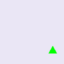

In [8]:
def decode_text(p_vocab, word_idx_list, ignore_pad=False):
  if ignore_pad:
    line = " ".join([p_vocab.itos[word_idx] for word_idx in word_idx_list])
  else:
    line = " ".join([p_vocab.itos[word_idx] for word_idx in word_idx_list \
                   if word_idx != p_vocab.stoi["<pad>"]])
  return line
  
def display_img_from_file_path(f_path):
  return Image.fromarray(read_image(f_path).permute(1, 2, 0).numpy())

def display_normalized_tensor_img(p_tensor):
  numpy_img = ((p_tensor + 0.5) * 255.0).permute(1, 2, 0).numpy().astype(np.uint8)
  return Image.fromarray(numpy_img)

r_id = np.random.randint(0, len(train_image_ids))
print("Question: ", train_questions[r_id])
print("Ans: ", train_answers[r_id])

path = train_image_paths[train_image_ids[r_id]]
display_img_from_file_path(path)

**Define Datasets & dataloader**

In [9]:
class CustomQADataset(Dataset):
    def __init__(self, p_src_vocab, p_trg_vocab, \
                 p_tokenizer, p_token_max_len, train=True):

        if train:
          self.questions, self.answers, self.img_ids = get_train_questions()
          self.img_paths = get_train_image_paths()
        else:
          self.questions, self.answers, self.img_ids = get_test_questions()
          self.img_paths = get_test_image_paths()

        self.src_vocab = p_src_vocab
        self.trg_vocab = p_trg_vocab
        self.tokenizer = p_tokenizer
        self.max_tokens_size = p_token_max_len
        self.normalize = transforms.Normalize((0.485, 0.456, 0.406), \
                                (0.229, 0.224, 0.225))

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):

        # images are png or jpeg
        img_path = self.img_paths[self.img_ids[idx]]
        # scale the pixes values
        image = read_image(img_path)/255.0 - 0.5
        #image = self.normalize(read_image(img_path)/255.0)
        
        question = [self.src_vocab.stoi[word] \
                    for word in self.tokenizer(self.questions[idx])]
        ans = [self.trg_vocab.stoi[word] \
               for word in self.tokenizer(self.answers[idx])]

        pad_times = self.max_tokens_size - len(question)
        question = question + ([self.src_vocab.stoi["<pad>"]] * pad_times)

        ans_vec = torch.zeros(len(self.trg_vocab))
        ohe_vec = torch.zeros(len(self.src_vocab))

        ''' Bag of words, frequency based'''
        for word_idx in question:
          ohe_vec[word_idx] += 1

        for word_idx in ans:
          ans_vec[word_idx] += 1

        sample = {"image": image, "question": torch.tensor(question), \
                  "ans": torch.tensor(ans),
                  "ohe_question": ohe_vec, \
                  "ohe_ans": ans_vec}
        return sample

''' Create train & test data loader'''
train_dataloader = DataLoader(CustomQADataset(q_vocab, ans_vocab, \
                                              tokenizer, \
                                              token_max_len, \
                                              train=True), \
                              batch_size=8, shuffle=True)

test_dataloader = DataLoader(CustomQADataset(q_vocab, ans_vocab, \
                                             tokenizer, \
                                             token_max_len, \
                                             train=False), \
                             batch_size=2, shuffle=True)

**Test the Loader**

Question:  what color is the rectangle ?
Ans:  red


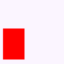

In [10]:
loader = iter(train_dataloader)
qa_img_pair = loader.next()

print("Question: ", decode_text(q_vocab, qa_img_pair["question"][0]))
print("Ans: ", decode_text(ans_vocab, qa_img_pair["ans"][0], \
                           ignore_pad=True))

display_normalized_tensor_img(qa_img_pair["image"][0])

**Define Model Architecture**

In [10]:
class VQAModel(nn.Module):
    def __init__(self, p_src_vocab, p_trg_vocab):
        super(VQAModel, self).__init__()
        ''' Define CNN model
            Change resnet fc layer to output 32 units
        '''
        #self.resnet = models.resnet18(pretrained=True)
        #self.resnet.fc = nn.Sequential(nn.Linear(in_features = 512, \
        #                                         out_features = 32), \
        #                               nn.Tanh())

        self.resnet = nn.Sequential(nn.Conv2d(3, 8, 3, padding=1), \
                                    nn.MaxPool2d(2), \
                                    nn.Conv2d(8, 16, 3, padding=1), \
                                    nn.MaxPool2d(2), \
                                    nn.Flatten(), \
                                   nn.Linear(in_features = 16 ** 3, out_features = 32), \
                                   nn.Tanh())

                                  
        self.fc_1 = nn.Linear(in_features = len(p_src_vocab), \
                              out_features = 32)
        self.tanh_1 = nn.Tanh()

        self.fc_2 = nn.Linear(in_features = 32, out_features = 32)
        self.tanh_2 = nn.Tanh()
        self.fc_3 = nn.Linear(in_features = 32 * 2, out_features = 32)
        self.tanh_3 = nn.Tanh()
        self.final_layer = nn.Linear(in_features=32, \
                                     out_features=len(p_trg_vocab))

    def forward(self, x):

        img_out = self.resnet(x["image"])
        text_out = self.tanh_1(self.fc_1(x["ohe_question"]))
        text_out = self.tanh_2(self.fc_2(text_out))

        ''' Do element wise multiplication on img & text feat'''
        concat_out = torch.cat([img_out, text_out], dim = 1)
        out = self.final_layer(self.tanh_3(self.fc_3(concat_out)))

        return out

**train & test Loop**

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):

    model.train()
    size = len(dataloader.dataset)
    for batch, qa_img_pair in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(qa_img_pair)
        loss = loss_fn(pred, qa_img_pair["ans"].squeeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(qa_img_pair)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for qa_img_pair in dataloader:
            pred = model(qa_img_pair)
            test_loss += loss_fn(pred, qa_img_pair["ans"].squeeze(1)).item()
            correct += (pred.argmax(1) == qa_img_pair["ans"].squeeze(1)).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, \
    Avg loss: {test_loss:>8f} \n")

**Main training**

In [14]:
#@title Default title text
''' Instantiate model'''
model = VQAModel(q_vocab, ans_vocab)

'''' Define loss_fn & optmizer'''
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 35
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.599878  [    0/38575]
loss: 1.126311  [ 2500/38575]
loss: 0.777979  [ 5000/38575]
loss: 1.251646  [ 7500/38575]
loss: 1.291346  [10000/38575]
loss: 0.630442  [12500/38575]
loss: 0.610634  [15000/38575]
loss: 0.813305  [17500/38575]
loss: 0.325095  [20000/38575]
loss: 0.738899  [22500/38575]
Test Error: 
 Accuracy: 69.4%,     Avg loss: 0.182319 

Epoch 2
-------------------------------
loss: 0.636425  [    0/38575]
loss: 1.009043  [ 2500/38575]
loss: 0.504934  [ 5000/38575]
loss: 0.253984  [ 7500/38575]
loss: 0.390205  [10000/38575]
loss: 0.819242  [12500/38575]
loss: 0.767383  [15000/38575]
loss: 0.837463  [17500/38575]
loss: 0.272549  [20000/38575]
loss: 0.508737  [22500/38575]
Test Error: 
 Accuracy: 73.2%,     Avg loss: 0.165950 

Epoch 3
-------------------------------
loss: 0.526720  [    0/38575]
loss: 0.785841  [ 2500/38575]
loss: 0.934744  [ 5000/38575]
loss: 0.325157  [ 7500/38575]
loss: 0.431896  [10000/38575]
loss: 0.490945  [1

In [15]:
torch.save(model.state_dict(), 'vqa_model_weights.pth')

**Load saved checkpoint**

In [12]:
model = VQAModel(q_vocab, ans_vocab)
model.load_state_dict(torch.load('vqa_model_weights.pth'))
model.eval()

VQAModel(
  (resnet): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4096, out_features=32, bias=True)
    (6): Tanh()
  )
  (fc_1): Linear(in_features=29, out_features=32, bias=True)
  (tanh_1): Tanh()
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (tanh_2): Tanh()
  (fc_3): Linear(in_features=64, out_features=32, bias=True)
  (tanh_3): Tanh()
  (final_layer): Linear(in_features=32, out_features=13, bias=True)
)

**Inference on Test set**

Question:  what shape is present ?
Ans:  rectangle
predicted class:  rectangle


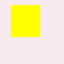

In [33]:
test_img = None
for img_pair in test_dataloader:
  print("Question: ", decode_text(q_vocab, img_pair["question"][0]))
  print("Ans: ", decode_text(ans_vocab, img_pair["ans"][0], \
                             ignore_pad=True))

  pred = model(img_pair)
  pred_idx = torch.argmax(pred[0]).item()
  #print("prediction idx: ", pred_idx)
  print("predicted class: ", ans_vocab.itos[pred_idx])

  test_img = display_normalized_tensor_img(img_pair["image"][0])
  break
test_img